In [46]:
from game import WordleGame
from solver import * 
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import re
from matplotlib.ticker import MultipleLocator
from joblib import Parallel, delayed


%matplotlib inline

%config InlineBackend.figure_format='retina'

In [2]:
guessable = open("guessable.csv").read().splitlines()
N = len(guessable)

In [ ]:
def make_pi(guessable, target):
    # pi is N x 2315 x 5 where pi[i,j] is reward for guessing i when j is correct
    N = len(guessable)
    pi = np.zeros(shape=(N, 2315, 5))
    for j in trange(2315):
        w = WordleGame(word=target[j])
        for i in range(N):
            if guessable[i] == target[j]:
                pi[i,j] = np.ones(5)
            else:
                pi[i,j] = w.turn(guessable[i])
    return pi

In [ ]:
pi_full = make_pi(guessable, words)

In [ ]:
pi_target = make_pi(words, words)

In [3]:
pi_target = np.load("pi_target.npy")
pi_full = np.load("pi_full.npy")

In [14]:
tau_full = pi_full.sum(axis=2)
tau_target = pi_target.sum(axis=2)

guessable[np.argmax(tau_full.sum(axis=0))]

'burry'

In [6]:
np.array_equal(tau_target.T, tau_target)

False

In [52]:
def maximum_information_v2_solver(game, tau_full, tau_target, mu=0.5):
    """
    Solve game using maximum information v2 strategy.
    
    Use axis 1 (the explore axis) until reward exceeds mu, then 
    use axis 0 (the exploit axis)
    
    """
    word_mask_full = np.ones(shape=(N, 2315)) # 1 means word is still valid, 0 means it's not
    word_mask_target = np.ones(shape=(2315, 2315))
    letter_mask = ["."] * 5 # mask for each letter
    poss = set() # required letters
    result = []
    while not game.solved:
        # reduce tau by elementwise multiplying by word_mask
        tau_full = np.multiply(tau_full, word_mask_full)
        tau_target = np.multiply(tau_target, word_mask_target)
        if (game.curr_step == 0) == (sum(result) <= mu):
            # exploit mode
            word_idx = np.argmax(tau_target.sum(axis=0))
            guess = words[word_idx]
        else:
            # explore mode
            word_idx = np.argmax(tau_full.sum(axis=1))
            guess = guessable[word_idx]

        result = game.turn(guess)
        # update masks based on result
        letter_mask, poss = update_mask(result, guess, letter_mask, poss)
        word_mask_full = update_word_mask(word_mask_full, letter_mask, poss)
        word_mask_target = update_word_mask(word_mask_target, letter_mask, poss)
    
    return game.score

In [53]:
w = WordleGame(verbose=2)

In [54]:
maximum_information_v2_solver(w, tau_full, tau_target)

stare => ⬛ ⬛ ⬛ ⬛ 🟩
clone => ⬛ ⬛ 🟩 ⬛ 🟩
biome => 🟩 🟩 🟩 🟩 🟩
Wordle solved in 3 steps. Score: 3


3

In [55]:
w.reset()
maximum_information_solver(w, tau_target)

stare => ⬛ ⬛ ⬛ ⬛ 🟩
clone => ⬛ ⬛ 🟩 ⬛ 🟩
biome => 🟩 🟩 🟩 🟩 🟩
Wordle solved in 3 steps. Score: 3


3

In [47]:
def play_vs_steps(target_word):
    game = WordleGame(word=target_word)
    maximum_information_solver(game, tau_target)
    v1_steps = game.curr_step
    game.reset()
    maximum_information_v2_solver(game, tau_full, tau_target)
    v2_steps = game.curr_step
    return v1_steps, v2_steps
    
steps = Parallel(n_jobs=-1, verbose=2)(delayed(play_vs_steps)(tw) for tw in words)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 2315 out of 2315 | elapsed: 14.7min finished


In [50]:
steps_v1 = list(map(lambda x: x[0], steps))
steps_v2 = list(map(lambda x: x[1], steps))
step_v1_cdf = [np.sum(np.array(steps_v1) <= i) / 2315 for i in range(max(steps_v1) + 1)]
step_v2_cdf = [np.sum(np.array(steps_v2) <= i) / 2315 for i in range(max(steps_v2) + 1)]

In [61]:
step_v1_cdf

[0.0,
 0.00043196544276457883,
 0.05745140388768898,
 0.4120950323974082,
 0.8004319654427646,
 0.9507559395248381,
 0.988768898488121,
 0.9982721382289417,
 0.9995680345572354,
 1.0]

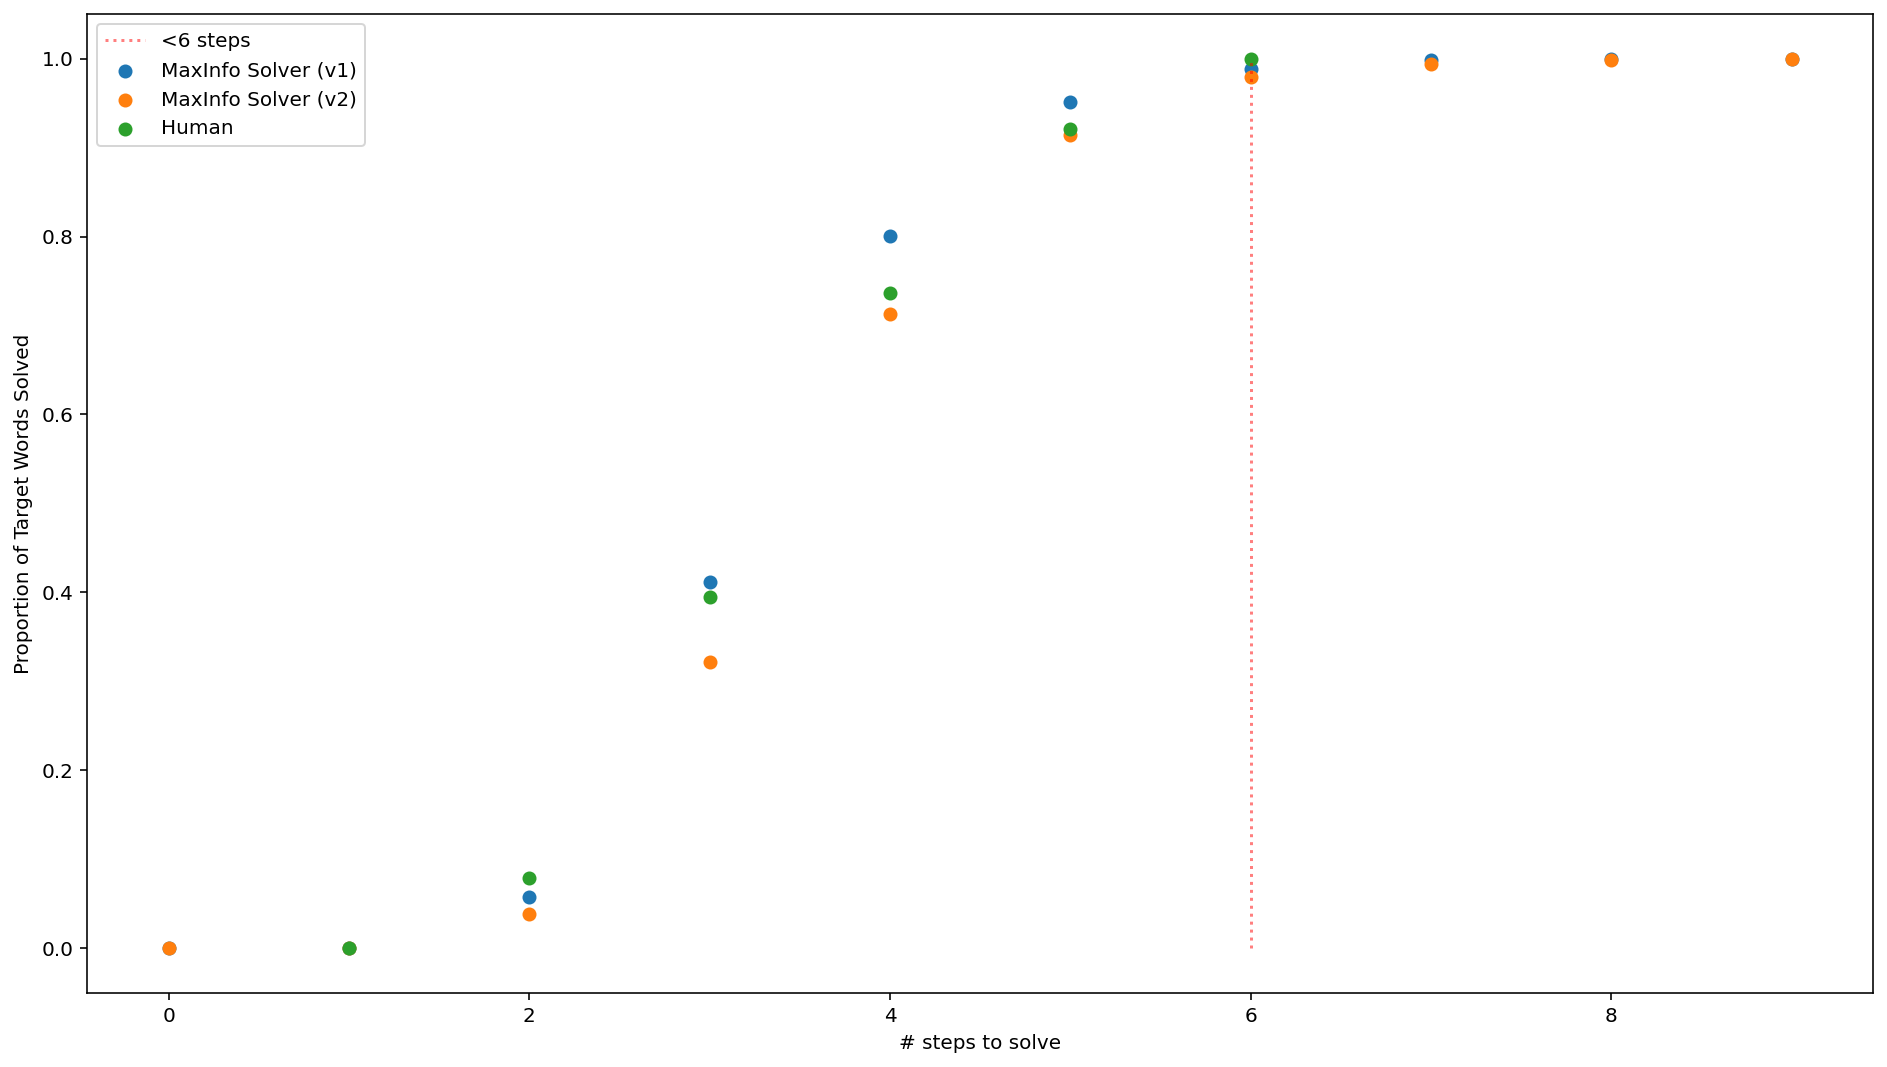

In [63]:
plt.figure(figsize=(16, 9))
plt.xlabel("# steps to solve")
plt.ylabel("Proportion of Target Words Solved")
plt.scatter(list(range(len(step_v1_cdf))), step_v1_cdf, label='MaxInfo Solver (v1)')
plt.scatter(list(range(len(step_v2_cdf))), step_v2_cdf, label='MaxInfo Solver (v2)')
plt.scatter([1, 2, 3, 4, 5, 6], [0, 6/76, 30/76, 56/76, 70/76, 76/76], label='Human')
plt.plot([6, 6], [0, 1], alpha=0.5, c='r', linestyle=':', label='<6 steps')
plt.legend()